In [1]:
%pylab inline
import os
import pandas as pd
import networkx as nx
import powerlaw
import seaborn as sns
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from tqdm.notebook import tqdm

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
important_years = {
    1972 : 'Title IX',
    1993 : 'FMLA'
}

In [3]:
# define some function
def fit_powerlaw(degrees, xmin=None, xmax=None):
    """ Fits the degree distribution with a power-law and return the Fit object.
    """
    fit = powerlaw.Fit(degrees, discrete=True, xmin=xmin, xmax=xmax)
    return fit

### Load data

In [4]:
def make_network():
    
    G = nx.Graph()
    
    with open("../data/collab_network_bravo/AuthorNodes.csv", 'rt') as rr:
        for n, line in enumerate(rr):
            
            if n == 0:
                # it is the header
                continue
            node_id, gender, _, _ = line.strip().split(",")
            G.add_node(node_id, gender=gender, bipartite=0)
            
    with open("../data/collab_network_bravo/PublicationNodes.csv", 'rt') as rr:
        for n, line in enumerate(rr):
            
            if n == 0:
                # it is the header
                continue
            node_id, year = line.strip().split(",")
            G.add_node(node_id, year=year, bipartite=1)
            
    with open("../data/collab_network_bravo/Edges.csv", 'rt') as rr:
        for n, line in enumerate(rr):
            
            if n == 0:
                # it is the header
                continue
            author, paper, auth_position = line.strip().split(",")
            G.add_edge(author, paper, position=auth_position)
            
    return G

In [5]:
# load data
# separately 
authors = pd.read_csv("../data/collab_network_bravo/AuthorNodes.csv").rename(columns={'Author_Node_ID':'author_id', 
                                                                 'Gender_Label_Refined':'gender'}).astype(str)
authors = authors[['author_id', 'gender']]
publications = pd.read_csv("../data/collab_network_bravo/PublicationNodes.csv", 
                           converters={'Publication_Node_ID':str, 
                                       'Year':int}).rename(columns={'Publication_Node_ID':'publication_id', 
                                                                           'Year':'year'})
edges = pd.read_csv("../data/collab_network_bravo/Edges.csv",
                    converters={'Publication_Node_ID':str,
                                'Author_Node_ID':str,
                                'Year':int}).rename(columns={'Author_Node_ID':'author_id', 
                                                             'Publication_Node_ID':'publication_id',
                     'position':'Author_Position'})

all_author_ids = set(authors.author_id.astype(str))
all_author_male = set(authors.query("gender == 'male'").author_id)
all_author_female = set(authors.query("gender == 'female'").author_id)
all_publications_ids = set(publications.publication_id.astype(str))

n_authors_gender = authors.gender.value_counts()

# load as a network
G = make_network()

# make also the networks of specific years
network_years = {}
for year in [1972, 1993, 2016]:
    pubblications_year = publications.query(f"year <= {year}")
    G_year = nx.from_pandas_edgelist(edges[edges.publication_id.isin(pubblications_year.publication_id)],
                                    source='author_id', target='publication_id', create_using=nx.Graph)
    nx.set_node_attributes(G_year, authors[['author_id', 'gender']].set_index('author_id').to_dict()['gender'],
                      name='gender')
    nx.set_node_attributes(G_year, publications[['publication_id', 'year']].set_index('publication_id').to_dict()['year'],
                          name='year')
    network_years[year] = G_year

print("Number of Authors: ", authors.shape[0])
print("Number of Publications: ", publications.shape[0])
print("Number of authorship relationships: ", edges.shape[0])
print()
print(f"Number of males: {n_authors_gender['male']} ({round(n_authors_gender['male']/n_authors_gender.sum()*100, 2)}%)")
print(f"Number of females: {n_authors_gender['female']} ({round(n_authors_gender['female']/n_authors_gender.sum()*100, 2)}%)")
print(f"Number of unknown gender: {n_authors_gender['unknown']} ({round(n_authors_gender['unknown']/n_authors_gender.sum()*100, 2)}%)")


Number of Authors:  22911
Number of Publications:  23875
Number of authorship relationships:  50527

Number of males: 16179 (70.62%)
Number of females: 2997 (13.08%)
Number of unknown gender: 3735 (16.3%)


In [6]:
# enrich data
# merge the authors' gender
edges = edges.merge(authors, on='author_id', how='left')

# merge the publications' year
edges = edges.merge(publications, on='publication_id', how='left')

# merge n_publications
authors = authors.set_index('author_id').merge(edges.author_id.value_counts().rename('n_publications'), 
                                     left_index=True, right_index=True, how='left').reset_index()

# project network
G_authors = nx.bipartite.weighted_projected_graph(G, nodes=authors.author_id)
G_pubblications = nx.bipartite.weighted_projected_graph(G, nodes=publications.publication_id)

In [13]:
# is there big CC in authors net
authors_cc = list(nx.connected_components(G_authors))
authors_cc = sorted(authors_cc, key=len, reverse=True)

print(f"Largest CC includes {len(authors_cc[0])} out of {G_authors.number_of_nodes()} \
      authors ({round( len(authors_cc[0]) / len(all_author_ids) * 100, 4)}%).")
print(f"Second largest CC includes {len(authors_cc[1])} out of {G_authors.number_of_nodes()} \
      authors ({round( len(authors_cc[1]) / len(all_author_ids) * 100, 4)}%).")

G_authors_bcc = G_authors.subgraph(authors_cc[0])

Largest CC includes 13520 out of 22911       authors (59.011%).
Second largest CC includes 21 out of 22911       authors (0.0917%).


### Number of publications

Calculating best minimal value for power law fit
/mnt/sdb1/lorenzo/miniconda3/envs/env-final-project-collaborations/lib/python3.10/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
/mnt/sdb1/lorenzo/miniconda3/envs/env-final-project-collaborations/lib/python3.10/site-packages/powerlaw.py:699: RuntimeWarning: divide by zero encountered in divide
  (CDF_diff**2) /
Calculating best minimal value for power law fit


Males:
x_min = 14.0; alpha = 3.4561 ± 0.126
Females:
x_min = 5.0; alpha = 2.9785 ± 0.1447


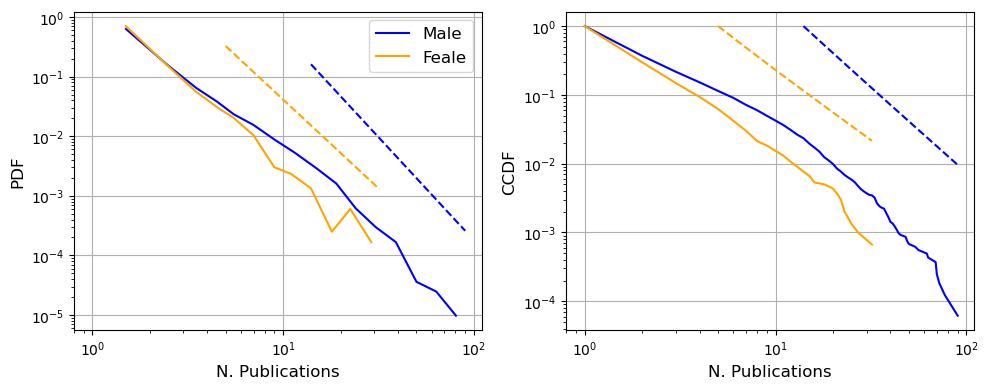

In [11]:
# plot male and female distribution of n_publications
plt.figure(figsize=(10,4))

fit_male = fit_powerlaw(authors.query("gender == 'male'").n_publications)
fit_female = fit_powerlaw(authors.query("gender == 'female'").n_publications)

print("Males:")
print(fr"x_min = {fit_male.xmin}; alpha = {round(fit_male.alpha, 4)} ± {round(fit_male.sigma, 4)}")
print("Females:")
print(fr"x_min = {fit_female.xmin}; alpha = {round(fit_female.alpha, 4)} ± {round(fit_female.sigma, 4)}")

for n_plot, plot_f_name in enumerate(["PDF", "CCDF"]):
    ax_ = plt.subplot(1, 2, n_plot + 1)
    
    if plot_f_name == 'PDF':
        powerlaw.plot_pdf(fit_male.data_original, label='Male', color='blue', ax=ax_)
        fit_male.power_law.plot_pdf(linestyle='dashed', color='blue', ax=ax_)
        powerlaw.plot_pdf(fit_female.data_original, label='Feale', color='orange', ax=ax_)
        fit_female.power_law.plot_pdf(linestyle='dashed', color='orange', ax=ax_)
    elif plot_f_name == 'CCDF':
        ax_ = powerlaw.plot_ccdf(fit_male.data_original, label='Male', color='blue', ax=ax_)
        fit_male.power_law.plot_ccdf(linestyle='dashed', color='blue', ax=ax_)
        powerlaw.plot_ccdf(fit_female.data_original, label='Feale', color='orange', ax=ax_)
        fit_female.power_law.plot_ccdf(linestyle='dashed', color='orange', ax=ax_)
        
    plt.xlabel("N. Publications", fontsize=12)
    plt.ylabel(plot_f_name, fontsize=12)
    plt.xlim(0.8, 110)

    plt.grid()
    if n_plot == 0:
        plt.legend(fontsize=12)

plt.tight_layout()

Year:  1972
Males:
x_min = 1.0; alpha = 1.9427 ± 0.0226
Females:
x_min = 1.0; alpha = 2.2158 ± 0.1793

Year:  1993
Males:
x_min = 1.0; alpha = 1.8745 ± 0.011
Females:
x_min = 1.0; alpha = 2.0958 ± 0.0491

Year:  2016
Males:
x_min = 1.0; alpha = 1.8537 ± 0.0067
Females:
x_min = 1.0; alpha = 1.975 ± 0.0178



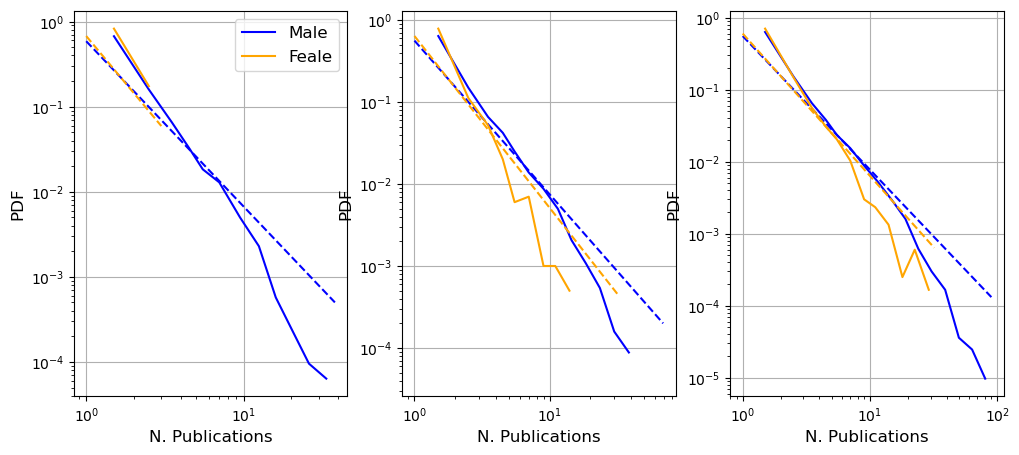

In [16]:
# do the same for the specific years
plt.figure(figsize=(12, 5))

for n_plot, (year, G_) in enumerate(network_years.items(), 1):
    
    ax_ = plt.subplot(1, len(network_years), n_plot)
    nodes_male_ = [node for node, att in G_.nodes(data=True) if 'gender' in att.keys() 
                   and att['gender'] == 'male']
    nodes_female_ = [node for node, att in G_.nodes(data=True) if 'gender' in att.keys() 
                     and att['gender'] == 'female']
    
    degrees_male_ = [deg for node, deg in G_.degree(nodes_male_) if deg > 0]
    degrees_female_ = [deg for node, deg in G_.degree(nodes_female_) if deg > 0]
    
    fit_male_ = fit_powerlaw(degrees_male_, xmin=1)
    fit_female_ = fit_powerlaw(degrees_female_, xmin=1)
    
    powerlaw.plot_pdf(fit_male_.data_original, label='Male', color='blue', ax=ax_)
    fit_male_.power_law.plot_pdf(linestyle='dashed', color='blue', ax=ax_)
    powerlaw.plot_pdf(fit_female_.data_original, label='Feale', color='orange', ax=ax_)
    fit_female_.power_law.plot_pdf(linestyle='dashed', color='orange', ax=ax_)

    plt.xlabel("N. Publications", fontsize=12)
    plt.ylabel("PDF", fontsize=12)
    #plt.xlim(0.8, 110)
    plt.grid()
    if n_plot == 1:
        plt.legend(fontsize=12)
        
    print("Year: ", year)
    print("Males:")
    print(fr"x_min = {fit_male_.xmin}; alpha = {round(fit_male_.alpha, 4)} ± {round(fit_male_.sigma, 4)}")
    print("Females:")
    print(fr"x_min = {fit_female_.xmin}; alpha = {round(fit_female_.alpha, 4)} ± {round(fit_female_.sigma, 4)}")
    print()

#### Per year

<AxesSubplot:xlabel='year'>

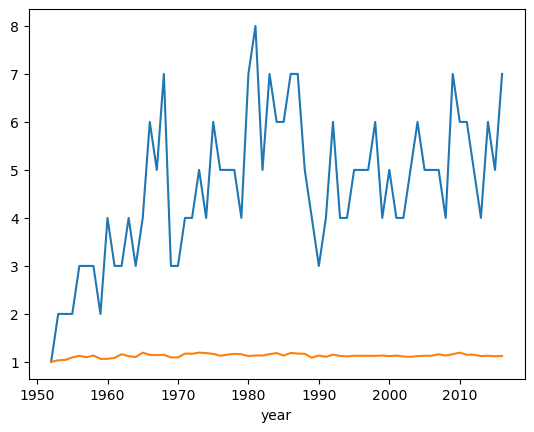

In [224]:
edges.groupby('year').apply(lambda rows: rows.author_id.value_counts().max()).plot()
edges.groupby('year').apply(lambda rows: rows.author_id.value_counts().mean()).plot()

### Strength of weak ties hypothesis

#### Basic definition

In [192]:
weakness_ties = np.array([(len(list(nx.common_neighbors(G_authors_bcc, i, j))), w) 
                          for i, j, w in G_authors_bcc.edges(data='weight')])

In [193]:
stats.spearmanr(weakness_ties[:,0], weakness_ties[:,1])

SpearmanrResult(correlation=0.04356165196555277, pvalue=7.497649540152887e-14)

In [194]:
stats.kendalltau(weakness_ties[:,0], weakness_ties[:,1])

KendalltauResult(correlation=0.038475025557030494, pvalue=3.430510511676259e-14)

Very weak powitive correlation, meaning the stronger a tie, the higher the number of common neighbors. 

#### Adjusted definition of weights

From Pan, Raj Kumar, and Jari Saramäki. "The strength of strong ties in scientific collaboration networks." EPL (Europhysics Letters) 97.1 (2012): 18007.

In [111]:
G['1046675']

AtlasView({'5000449': {'position': '3'}, '5007524': {'position': '1'}, '5016914': {'position': '1'}})

In [115]:
nx.ego_graph(G, '1046675', radius=2).nodes()

NodeView(('5016914', '1049492', '1046675', '1049147', '1030691', '1030813', '5000449', '5007524', '1029576', '1026213'))

In [116]:
nx.single_source_shortest_path_length(G, '1046675', cutoff=2)

{'1046675': 0,
 '5016914': 1,
 '5000449': 1,
 '5007524': 1,
 '1049492': 2,
 '1049147': 2,
 '1030691': 2,
 '1030813': 2,
 '1029576': 2,
 '1026213': 2}

In [119]:
def get_all_collabs(G, node):
    return [node for node, d in nx.single_source_shortest_path_length(G, '1046675', cutoff=2).items() 
            if d == 2]

In [170]:
def compute_adj_weight(G, i, j):
    return sum([(G.degree(common_paper) - 1) ** (-1) for common_paper in nx.common_neighbors(G, i, j)
               if G.degree(common_paper) < 10])
        


In [171]:
nx.set_edge_attributes(G_authors_bcc, {(i, j) : compute_adj_weight(G, i, j) for i, j in G_authors_bcc.edges()},
                      name='weight_adj')

In [206]:
weakness_ties = np.array([(len(list(nx.common_neighbors(G_authors_bcc, i, j))), w) 
                          for i, j, w in G_authors_bcc.edges(data='weight_adj') if w > 0])

In [213]:
stats.spearmanr(weakness_ties[:,0], weakness_ties[:,1])

SpearmanrResult(correlation=-0.7136848714959243, pvalue=0.0)

In [214]:
stats.kendalltau(weakness_ties[:,0], weakness_ties[:,1])

KendalltauResult(correlation=-0.6814823101184937, pvalue=0.0)

In [215]:
stats.pearsonr(weakness_ties[:,0], weakness_ties[:,1])

PearsonRResult(statistic=-0.21210021108913701, pvalue=1.9847621993234614e-272)

### Brokerage

In [31]:
# compute constraints (the lower, the more brokerage position)
constraints_authors = nx.constraint(G_authors_bcc)

In [32]:
authors = authors.set_index('author_id').merge(pd.Series(constraints_authors, name='constraint'), 
                                     left_index=True, right_index=True, how='left').reset_index()

In [34]:
stats.kendalltau(authors.dropna(subset=['constraint']).n_publications,
                authors.dropna(subset=['constraint']).constraint,)

KendalltauResult(correlation=-0.5768424825767421, pvalue=0.0)

In [35]:
stats.spearmanr(authors.dropna(subset=['constraint']).n_publications,
                authors.dropna(subset=['constraint']).constraint,)

SpearmanrResult(correlation=-0.6947072940420089, pvalue=0.0)

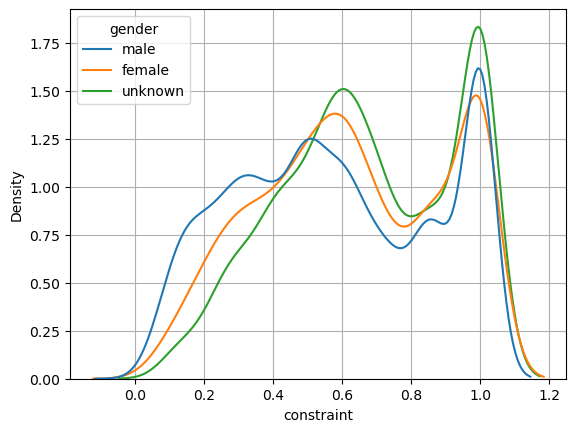

In [48]:
sns.kdeplot(authors, x='constraint', hue='gender', common_norm=False)
plt.grid()

<AxesSubplot:xlabel='gender', ylabel='constraint'>

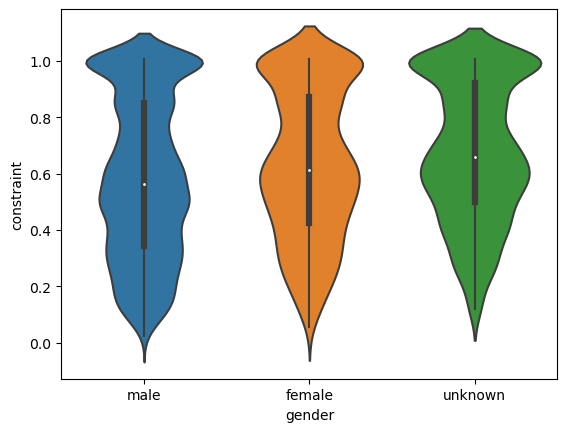

In [68]:
sns.violinplot(authors, y='constraint', x='gender')

In [69]:
# ANOVA shows theey have different means
stats.f_oneway(*(authors.query(f"gender == '{gend}'").constraint.dropna().values
                for gend in authors.gender.unique() ) )

F_onewayResult(statistic=98.72618649286206, pvalue=2.7158579654436794e-43)

In [70]:
# make post-hoc tests to see how has diifferent mean from who
turkey_t = pairwise_tukeyhsd(authors.dropna(subset=['constraint']).constraint, 
                  authors.dropna(subset=['constraint']).gender)
print(turkey_t)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2 meandiff p-adj  lower   upper  reject
----------------------------------------------------
female    male  -0.0479   0.0 -0.0643 -0.0314   True
female unknown   0.0439   0.0  0.0229   0.065   True
  male unknown   0.0918   0.0  0.0756   0.108   True
----------------------------------------------------


In [256]:
authors.loc[:, 'n_coautors'] = authors.author_id.apply(lambda aut: G_authors.degree(aut))

In [259]:
authors[['constraint', 'n_coautors']].corr(method='spearman')

,constraint,n_coautors
constraint,1.000000,-0.906332
n_coautors,-0.906332,1.000000


<AxesSubplot:xlabel='n_coautors', ylabel='constraint'>

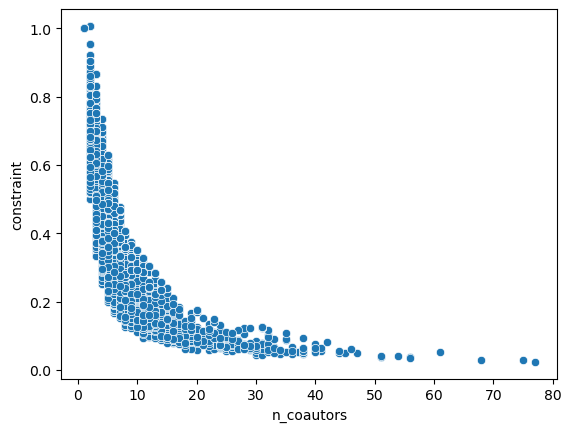

In [262]:
sns.scatterplot(authors, x='n_coautors', y='constraint')

<AxesSubplot:xlabel='n_publications', ylabel='constraint'>

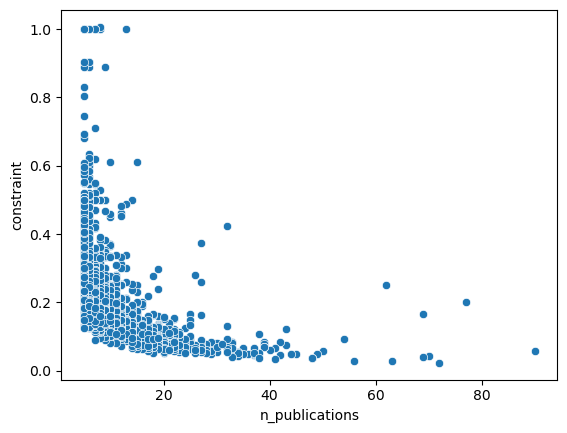

In [279]:
sns.scatterplot(authors[authors.n_publications > 4], x='n_publications', y='constraint')

In [283]:
len(list(nx.connected_components(G_pubblications)))

4587

In [284]:
comms = nx.community.label_propagation_communities(G_pubblications.\
                           subgraph(max(nx.connected_components(G_pubblications), key=len)))

In [285]:
len(comms)

1305

(array([1.159e+03, 7.500e+01, 3.800e+01, 1.200e+01, 9.000e+00, 3.000e+00,
        3.000e+00, 1.000e+00, 3.000e+00, 2.000e+00]),
 array([  2. ,  24.4,  46.8,  69.2,  91.6, 114. , 136.4, 158.8, 181.2,
        203.6, 226. ]),
 <BarContainer object of 10 artists>)

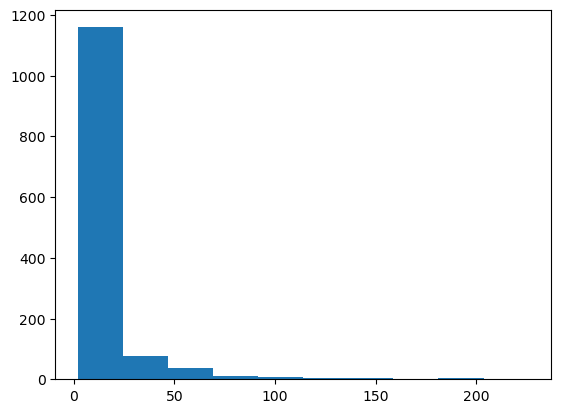

In [287]:
plt.hist([len(c) for c in comms])

In [288]:
nx.community.modularity(G_pubblications.\
                           subgraph(max(nx.connected_components(G_pubblications), key=len)), comms)

0.8262080177689517

### Gender and number of publications

### Assortativity

In [77]:
nx.attribute_assortativity_coefficient(G_authors_bcc, attribute='gender')

0.1733553871495423

In [78]:
nx.attribute_assortativity_coefficient(G_authors_bcc, attribute='gender', 
                                       nodes=all_author_male.union(all_author_female))

0.06401272426518709

In [79]:
for year, G_ in network_years.items():
    
    node_authors_ = [node for node, att in G_.nodes(data=True) if 'gender' in att.keys()]
    G_authors_ = nx.bipartite.project(G_, nodes=node_authors_, create_using=nx.Graph)
    ass_1 = nx.attribute_assortativity_coefficient(G_authors_, attribute='gender')
    ass_2 = nx.attribute_assortativity_coefficient(G_authors_, attribute='gender', 
                                       nodes=all_author_male.union(all_author_female))
    
    print("Year: ", year)
    print(ass_1, ass_2)

Year:  1972
0.4581330507671909 -0.005408128909827502
Year:  1993
0.4465918188902279 0.024025417869390674
Year:  2016
0.20396956747789768 0.0676748759778766


In [80]:
nx.attribute_mixing_matrix(G_authors, attribute='gender', normalized=False,
                           mapping={'male':0, 'female':1, 'unknown':2})

array([[43850.,  6708.,  4748.],
       [ 6708.,  2002.,   680.],
       [ 4748.,   680.,  4016.]])

### Friendship paradox males and females with publications

In [89]:
# addd information about n_papers of nearest neighbors
authors.loc[:, 'n_publications_nn'] = authors.author_id.apply(lambda id_: 
                 authors[authors.author_id.isin(G_authors.neighbors(id_))].n_publications.mean())

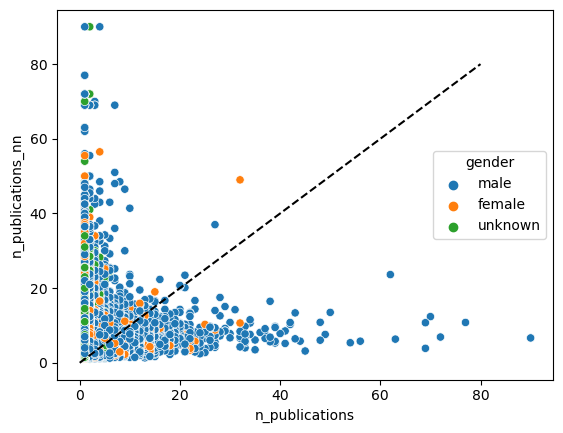

In [98]:
sns.scatterplot(authors.dropna(subset=['constraint']), x='n_publications', y='n_publications_nn', hue='gender')
plt.plot([0, 80], [0, 80], color='black', linestyle='dashed')

In [102]:
(authors.n_publications < authors.n_publications_nn).value_counts(1)

True     0.584566
False    0.415434
dtype: float64

In [104]:
authors.groupby('gender').apply(lambda rows: 
                                (rows.n_publications < rows.n_publications_nn).value_counts(1) )

,True,False
gender,,
female,0.650984,0.349016
male,0.565857,0.434143
unknown,0.612316,0.387684


### Info from data (e.g., seniority)

In [231]:
edges.groupby('author_id').apply(lambda rows: (rows.year.min(), rows.year.max(), ))

author_id
1024459    (2004, 2016)
1024460    (2001, 2001)
1024462    (1995, 1995)
1024463    (2006, 2014)
1024464    (1997, 1997)
               ...     
1050147    (2013, 2013)
1050150    (2015, 2015)
1050152    (2013, 2013)
1050155    (2013, 2013)
1050162    (2011, 2011)
Length: 22911, dtype: object

In [263]:
def get_author_publication_info(df_author):
    
    df_author = df_author.sort_values("year")
    year_start = df_author.year.min()
    year_end = df_author.year.max()
    
    first_is_first_author = df_author.iloc[0].Author_Position == 1
    df_author_more1 = df_author[df_author.Author_Position > 1]
    
    if df_author_more1.shape[0] > 0:
        years_to_not_first_author = df_author[df_author.Author_Position > 1].iloc[0].year - year_start
    else:
        years_to_not_first_author = None
        
    #return year_start, year_end, first_is_first_author, years_to_not_first_author
    return years_to_not_first_author

In [266]:
yyy = edges.groupby('author_id').apply(get_author_publication_info)
